# MEMO

* 16년도의 제주도산 감귤(, 무, 양배추)에 대해서 거래도매시장별로 kg당 단가(TOT_AMT / TOT_ATY)의 평균을 알아본다. 
* 거래도매시장에 대한 위도, 경도 column을 추가하고
* plotly 지도에 추가하고 line을 그린다. (색상과 opactiy로 가격의 크기를 표현) ** 굵기로 하는 법 찾아보기

* 기상청데이터로 가설 하나 만들 수도 있을 것 같음
* **github에 plotly 차트 display하는 방법 찾기**

## 데이터 출처
* DACON - 2021 농산물 가격예측 AI 경진대회 (https://dacon.io/competitions/official/235801/data)

## 데이터 정보

기간 : 2016-01 ~ 2020-09

- train.csv 
  - date : 일자
  - 요일 : 요일
  - 품목_거래량(kg) : 해당 품목의 거래량
  - 품목_가격(원/kg) : 해당 품목의 kg당 가격
  - 품목_가격 산출 방식 : 품목 또는 품종의 총 거래금액 / 총 거래량 (취소된 거래내역 제외)  
- train_AT_TSALET_ALL : 월별 전국 도매시장 거래정보 데이터
  - SALEDATE: 경락 일자
  - WHSAL_NM: 도매시장
  - CMP_NM: 법인
  - PUM_NM: 품목
  - KIND_NM: 품종
  - DAN_NM: 단위
  - POJ_NM: 포장
  - SIZE_NM: 크기
  - LV_NM: 등급
  - SAN_NM: 산지
  - DANQ: 단위중량
  - QTY: 물량
  - COST: 단가
  - TOT_QTY: 총물량 (음수로 집계된 값은 거래 취소 내역)
  - TOT_AMT: 총금액

## 가설 설정
1. 김장철이 되면 배추 가격이 상승할 것이다.
    - 총 기간동안 배추 가격의 변화를 linegraph로 확인
    - 김장시즌(11월~12월)에 배경색을 입혀 표시한다면 가독성이 좋을 것 같음.
    - 추가적으로 월별 배추 가격의 변화에 대해서 살펴보면서 11월~12월에 김장(가을)배추의 가격과 다른 배추들의 가격이 어떤 차이가 있는지도 알아보면 좋을 것 같음.

2. 코로나 발생(2020년 1월 기준) 이후로 중국산 농산물의 거래량과 가격의 변화가 있었을 것이다. (거래량은 줄었을 것이고 가격은 올랐을 것이다.)
    - 모든 수입 농산물에 대해서도 생각해 볼 수 있겠지만, 코로나 발생 당시 중국은 엄격하게 중국 내외 이동을 봉쇄했기 때문에 한국의 입장에서 중국에서 들어오는 수입에도 차이가 생겼을 것이라고 생각했음. 
    - 2020년 1월을 표시하도록 line을 그리고 그 이후의 기간에 background-color를 입혀서 보기 편하도록 시각화
    - 추가적으로 그 이전의 기간동안 한국은 중국으로부터 어떤 품목을 가장 많이 수입해오고 있었는지 알아보고, 이를 국내산 동품목의 거래량과 비교해서 해당 품목의 수입산 의존도가 코로나 발생을 기준으로 어떻게 변화했는지 알아보는 것도 좋을 것 같음. (이 때 여러 종류의 plot 사용할 수 있을 것 같음)
    - 중국, 해외, 국내로 나누어서 한 그래프에서 가격, 거래량 변화 보기


3. 제주도에서 멀리 있는 지역의 도매시장에서 일어난 거래일수록 거래 가격이 비쌀 것이다.
    - folium 사용
    - 감귤 말고 다른 것도 해보기

4. 남부지방일수록 열대과일을 생산할 가능성이 높을 것이다. 
    - folium
    - 동남아에서 생산하는 품목들이 어떤 것인지 확인한 뒤, 그 품목들을 국내에서도 생산하는 지 확인한다.
    - 확인이 되면, 그 품목들에 대한 산지의 위도, 경도를 체크해서 column으로 추가한다.
    - 그 위도 경도를 품목별로 folium 지도에 marking한다.

5. 수입산 농산물과 국내산 농산물의 차이에 대해서 
    - "SAN_NM"을 이용 -> 수입산, 국내산 column을 추가)



## 해결해야 할 점
- 월별 도매시장 데이터가 csv 파일 여러개로 나뉘어져있는데 이걸 전부 하나로 merge하고 내가 원하는 데이터만 뽑는 게 좋을지, 아니면 내가 원하는 데이터만 뽑아서 merge하는 게 좋을지.
  - AT_TSALET_ALL_201601.csv (row 270만)
  - AT_TSALET_ALL_201602.csv
  - AT_TSALET_ALL_201603.csv
  - .....
- folium 쓸 때 크기 작게 출력하기

## 라이브러리

In [2]:
!pip install folium

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 95 kB 5.3 MB/s  eta 0:00:01


In [14]:
!pip install plotly

Defaulting to user installation because normal site-packages is not writeable


In [122]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import warnings
import folium
from tqdm import tqdm
import plotly.figure_factory as ff
import plotly.graph_objs as go
import plotly.express as px

## 설정

In [4]:
# 데이터 프레임의 모든 column을 볼 수 있도록 설정
pd.set_option('display.max_columns', None) 
# 한글
plt.rc('font', family='Malgun Gothic')
# warning 제거
warnings.filterwarnings(action='ignore')

## 경로

In [5]:
DATA_DIR = "../data_nongsanmul"
TRAIN_PATH = os.path.join(DATA_DIR, "train.csv")

## 월별 도매시장 거래 DATA 불러오는 함수

In [6]:
def TSALET_CSV(yearmonth):
    return pd.read_csv(os.path.join(DATA_DIR, "train_AT_TSALET_ALL/AT_TSALET_ALL_{}.csv".format(yearmonth)), parse_dates = ['SALEDATE'])

## 연별 도매시장 DataFrame을 concatenate하는 함수

In [7]:
def TSALET_CONCAT_YEAR(year):
    dt_index = pd.date_range(start="{}0101".format(str(year)), end="{}1231".format(str(year)), freq = "M")
    dt_list = dt_index.strftime("%Y%m").tolist()
    return pd.concat([TSALET_CSV(int(i)) for i in dt_list])

In [8]:
# 2016년 도매시장 데이터
df_2016 = TSALET_CONCAT_YEAR(2016)

In [9]:
unique_pum = [
    '배추', '무', '양파', '건고추','마늘',
    '대파', '얼갈이배추', '양배추', '깻잎',
    '시금치', '미나리', '당근',
    '파프리카', '새송이', '팽이버섯', '토마토',
]

In [10]:
# 2016년도 기준 품목별 주 생산지(국내)
joosan_dict = dict()


for pum in tqdm(unique_pum):
    df_pum = df_2016[df_2016["PUM_NM"]==pum]
    joosan_list = df_pum.groupby(["SAN_NM"])["TOT_QTY"].sum().sort_values(ascending=False).index
    for i in range(10):
        if joosan_list[i][-1] in ['군', '구', '도', '시']:
            joosan_dict[pum] = joosan_list[i]
            break

joosan_dict

100%|██████████| 16/16 [00:25<00:00,  1.57s/it]


{'배추': '전라남도 해남군',
 '무': '제주도 제주시',
 '양파': '전라남도 무안군',
 '건고추': '강원 춘천시',
 '마늘': '경상남도 창녕군',
 '대파': '전라남도 진도군',
 '얼갈이배추': '경기도 포천시',
 '양배추': '제주도 제주시',
 '깻잎': '경상남도 밀양시',
 '시금치': '경기도 포천시',
 '미나리': '경기도 시흥시',
 '당근': '제주도 제주시',
 '파프리카': '경상남도 진주시',
 '새송이': '충청남도 천안시',
 '팽이버섯': '경상북도 청도군',
 '토마토': '부산 강서구'}

## 가설 3 : 제주도에서 멀리 있는 지역의 도매시장에서 일어난 거래일수록 거래 가격이 비쌀 것이다.

In [15]:
# SAN_NM이 빈 칸인 칸을 NaN으로 대체
df_2016["SAN_NM"].replace('', np.NaN, inplace = True)

In [16]:
# SAN_NM이 빈 칸인 행 삭제
df_2016 = df_2016.dropna(subset = ["SAN_NM"], axis = 0)

In [20]:
df_2016.shape

(39507093, 15)

In [142]:
# 2016년 제주도산
df_2016_san_jeju = df_2016[df_2016["SAN_NM"].isin([i for i in df_2016["SAN_NM"].unique() if "제주" in i])]
df_2016_san_jeju.head()

,SALEDATE,WHSAL_NM,CMP_NM,PUM_NM,KIND_NM,DAN_NM,POJ_NM,SIZE_NM,LV_NM,SAN_NM,DANQ,QTY,COST,TOT_QTY,TOT_AMT
0,2016-01-09,부산엄궁도매,부산청과,감귤,조생귤,kg,상자,.,보통,제주도 제주시,10.0,62,14400.0,620.0,892800
1,2016-01-09,부산엄궁도매,부산청과,감귤,조생귤,kg,상자,.,보통,제주도 제주시,10.0,29,14700.0,290.0,426300
2,2016-01-09,부산엄궁도매,부산청과,감귤,조생귤,kg,상자,.,특,제주도 제주시,10.0,17,12800.0,170.0,217600
3,2016-01-09,부산엄궁도매,부산청과,감귤,조생귤,kg,상자,.,특,제주도 제주시,10.0,16,8800.0,160.0,140800
4,2016-01-09,부산엄궁도매,부산청과,감귤,조생귤,kg,상자,.,보통,제주 남제주군,10.0,25,7300.0,250.0,182500


In [248]:
# 2016년 제주도산 농산물의 품목별 전체 거래중량
grouped_san_jeju = df_2016_san_jeju.groupby(["PUM_NM"])["TOT_QTY"].sum().sort_values()
grouped_san_jeju = pd.DataFrame(data = grouped_san_jeju)

# 합이 1이 되도록 정규화
grouped_san_jeju["TOT_QTY"] /= grouped_san_jeju["TOT_QTY"].sum()
grouped_san_jeju["TOT_QTY"].sum()

1.0

In [215]:
# 2016년 제주도산 농산물의 품목별 전체 거래중량에서 0번 품목부터 117번 품목까지의 거래중량이 차지하는 비율이 1%
sum = 0
for i in range(0, 136):
    sum += grouped_san_jeju["TOT_QTY"][i]
    if sum > 0.01:
        print("0번부터 {}번 row({})까지의 합이 {}으로 처음 0.01을 넘는다.".format(i, grouped_san_jeju.index[i], sum))
        break

0번부터 117번 row(방울양배추(스프로스))까지의 합이 0.010649662644849484으로 처음 0.01을 넘는다.


In [241]:
# 0번부터 117번까지를 '기타'로 묶어서 새로운 column을 생성
etc_name = "기타"
etc_value = grouped_san_jeju["TOT_QTY"][0:118].sum()



In [249]:
# 0번부터 117번까지 '기타'로 묶고 새로운 grouped DataFrame을 생성
etc_data = {'PUM_NM' : etc_name, 'TOT_QTY' : etc_value}

grouped_san_jeju = grouped_san_jeju.drop(grouped_san_jeju.index[0:118]).reset_index().append(etc_data, ignore_index = True).set_index("PUM_NM")
grouped_san_jeju

,TOT_QTY
PUM_NM,
금감,0.002198
배추,0.002282
비트(붉은사탕무우),0.002590
참다래(키위),0.002646
마늘,0.004984
수박,0.004986
쪽파,0.005245
적채,0.005564
콜라비(순무양배추),0.007805


In [264]:
# 감귤, 무, 양배추가 2016년 제주도산 농산물 중 약 80%를 차지함

fig = px.pie(grouped_san_jeju, values = grouped_san_jeju["TOT_QTY"], names = grouped_san_jeju.index, color_discrete_sequence=px.colors.sequential.RdBu)
fig.update_traces(textposition='inside', textinfo='percent+label')

fig.show()

# 따라서 제주도산 감귤, 무, 양배추에 대해서 알아보기로 한다.

# 이거 참고해서 색상, opacity 조절하기

In [301]:
import plotly.graph_objects as go

fig = go.Figure(go.Scattermapbox(
    mode = "markers+lines",
    lon = [10, 20, 30],
    lat = [10, 20,30],
    marker = {'size': 10}))

fig.add_trace(go.Scattermapbox(
    mode = "markers+lines",
    lon = [-50, -60],
    lat = [30, 10],
    marker = {'size': 10, 'color': "#dddddd"}))

fig.update_layout(
    margin ={'l':0,'t':0,'b':0,'r':0},
    mapbox = {
        'center': {'lon': 10, 'lat': 10},
        'style': "stamen-terrain",
        'center': {'lon': -20, 'lat': -20},
        'zoom': 1})

fig.show()

In [21]:
df_joosan = pd.DataFrame(index = joosan_dict.keys(), data = joosan_dict.values(), columns = ["joosan"])
df_joosan_coord = pd.DataFrame(index = unique_pum,
             columns = ['latitude', 'longitude'],
            data = [[34.57360, 126.59896],
                    [33.49948, 126.53100],
                    [34.99038, 126.48167],
                    [37.88138, 127.73010],
                    [35.54463, 128.49246],
                    [34.48683, 126.26373],
                    [37.89497, 127.20036],
                    [33.49948, 126.53100],
                    [35.50378, 128.74658],
                    [37.89497, 127.20036],
                    [37.38017, 126.80281],
                    [33.49948, 126.53100],
                    [35.18013, 128.10744],
                    [36.81514, 127.11379],
                    [35.64737, 128.73457],
                    [37.15346, 127.08940]
                   ])

df_joosan_2016_info = pd.merge(df_joosan, df_joosan_coord, on = df_joosan.index).rename(columns = {"key_0" : "PUM"})
df_joosan_2016_info

,PUM,joosan,latitude,longitude
0,배추,전라남도 해남군,34.57360,126.59896
1,무,제주도 제주시,33.49948,126.53100
2,양파,전라남도 무안군,34.99038,126.48167
3,건고추,강원 춘천시,37.88138,127.73010
4,마늘,경상남도 창녕군,35.54463,128.49246
5,대파,전라남도 진도군,34.48683,126.26373
6,얼갈이배추,경기도 포천시,37.89497,127.20036
7,양배추,제주도 제주시,33.49948,126.53100
8,깻잎,경상남도 밀양시,35.50378,128.74658
9,시금치,경기도 포천시,37.89497,127.20036


In [31]:
map_osm = folium.Map(location=[35.9, 128], zoom_start = 7)

for i in range(0, 16):
    popup = df_joosan_2016_info.iloc[i,1]
    folium.Marker(df_joosan_2016_info.loc[i, ["latitude", "longitude"]].tolist(), popup = popup).add_to(map_osm)
map_osm

## DATA - 도매시장 거래 정보

In [24]:
# 농산물들의 산지는 어떻게 되는지
# 구분할 때 ['군', '구', '시', '도']가 마지막 글자인걸로 구분
df_2016_san = [str(i) for i in df_2016["SAN_NM"].unique().tolist()]
df_2016_san_domestic = []
df_2016_san_imported = []

for san in df_2016_san:
    if san[-1] in ["군", "구", "도", "시"]:
        df_2016_san_domestic.append(san)
    else:
        df_2016_san_imported.append(san)

print(df_2016_san_domestic)
print(df_2016_san_imported)

# 여기서 수입산에 한국, nan 처리해야함

['제주도 제주시', '제주 남제주군', '제주도 서귀포시', '부산 중구', '광주 북구', '전라북도 익산시', '전라남도 고흥군', '경상남도 통영시', '경상북도 봉화군', '경상남도 김해시', '경상남도 고성군', '경상남도 밀양시', '제주 북제주군', '대구 중구', '경상남도 양산시', '경상남도 창녕군', '경기도 여주군', '경상북도 청송군', '경상남도 합천군', '경상남도 남해군', '경상북도 청도군', '경남 창원시', '전라남도 해남군', '서울 송파구', '경상북도 경주시', '충청남도 서산시', '경상북도 군위군', '경상남도 함안군', '경상남도 의령군', '경상남도 진주시', '충청남도 부여군', '전라남도 여수시', '경상남도 산청군', '경상북도 영양군', '충청북도 영동군', '경상북도 구미시', '전라남도 담양군', '인천 부평구', '경북 청도군', '제주 제주시', '제주 서귀포시', '전남 나주시', '전남 함평군', '경기 광주시', '경기 양평군', '경기 고양시 일산서구', '전남 진도군', '경북 상주시', '경남 함안군', '전남 신안군', '인천 계양구', '충남 논산시', '인천 남구', '경남 창녕군', '경기 안성시', '경남 진주시', '광주 남구', '경남 하동군', '충남 부여군', '광주 광산구', '경기 안양시 만안구', '전남 영암군', '경남 밀양시', '충남 보령시', '충남 홍성군', '경북 의성군', '충북 충주시', '경기 김포시', '경남 남해군', '경북 포항시 남구', '전남 여수시', '전남 순천시', '경기 수원시 장안구', '경기 시흥시', '충남 예산군', '경기 화성시', '인천 강화군', '경기 광명시', '경기 파주시', '충남 당진군', '경기 양주시', '충남 청양군', '전남 해남군', '전북 고창군', '전북 완주군', '충남 서산시', '경남 산청군', '경남 고성군', '경기 구리시', '경북 영주시', '경북 청송군', '경상북도 안동시', '전남 무

In [17]:
# 2016년 배추 거래 정보
df_2016_baechu = df_2016[df_2016["PUM_NM"] == "배추"]
df_2016_baechu

,SALEDATE,WHSAL_NM,CMP_NM,PUM_NM,KIND_NM,DAN_NM,POJ_NM,SIZE_NM,LV_NM,SAN_NM,DANQ,QTY,COST,TOT_QTY,TOT_AMT
165,2016-01-09,부산엄궁도매,부산청과,배추,쌈배추,kg,상자,.,보통,광주 북구,10.0,25,6110.0,250.0,152750
262,2016-01-09,부산엄궁도매,부산청과,배추,쌈배추,kg,상자,.,보통,광주 북구,10.0,25,6200.0,250.0,155000
263,2016-01-09,부산엄궁도매,부산청과,배추,쌈배추,kg,상자,.,보통,광주 북구,10.0,25,6200.0,250.0,155000
325,2016-01-09,부산엄궁도매,부산청과,배추,기타배추,kg,단,.,보통,부산 중구,4.0,100,2500.0,400.0,250000
434,2016-01-09,부산엄궁도매,부산청과,배추,기타배추,kg,그물망,.,보통,전라남도 해남군,15.0,700,4000.0,10500.0,2800000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2872378,2016-12-31,서울가락도매,대아청과,배추,김장(가을)배추,kg,그물망,3개,상,전라남도 해남군,10.0,200,7900.0,2000.0,1580000
2872397,2016-12-31,서울가락도매,대아청과,배추,김장(가을)배추,kg,그물망,3개,특,전라남도 해남군,10.0,768,13500.0,7680.0,10368000
2872398,2016-12-31,서울가락도매,대아청과,배추,김장(가을)배추,kg,그물망,3개,상,전라남도 해남군,10.0,192,8100.0,1920.0,1555200
2872449,2016-12-31,서울가락도매,대아청과,배추,김장(가을)배추,kg,그물망,3개,특,전라남도 해남군,10.0,768,12600.0,7680.0,9676800


In [32]:
# 도매시장 지역 (한 도시에 도매시장 여러 개 있는 건 하나로 침)
set([i for i in df_2016['WHSAL_NM'].unique()])

{'강릉도매시장',
 '광주각화도매',
 '광주서부도매',
 '구리도매시장',
 '구미도매시장',
 '대구북부도매',
 '대전노은도매',
 '대전오정도매',
 '부산반여도매',
 '부산엄궁도매',
 '서울가락도매',
 '서울강서도매',
 '수원도매시장',
 '순천도매시장',
 '안동도매시장',
 '안산도매시장',
 '안양도매시장',
 '울산도매시장',
 '원주도매시장',
 '익산도매시장',
 '인천구월도매',
 '인천삼산도매',
 '전주도매시장',
 '정읍도매시장',
 '진주도매시장',
 '창원내서도매시장',
 '창원팔용도매시장',
 '천안도매시장',
 '청주도매시장',
 '춘천도매시장',
 '충주도매시장',
 '포항도매시장'}

## DATA - 품목별 거래량 합, 단가 평균 (2016-01 ~ 2020-09)

In [27]:
df = pd.read_csv(TRAIN_PATH, parse_dates=["date"], index_col = "date")
df.head(10)

,요일,배추_거래량(kg),배추_가격(원/kg),무_거래량(kg),무_가격(원/kg),양파_거래량(kg),양파_가격(원/kg),건고추_거래량(kg),건고추_가격(원/kg),마늘_거래량(kg),마늘_가격(원/kg),대파_거래량(kg),대파_가격(원/kg),얼갈이배추_거래량(kg),얼갈이배추_가격(원/kg),양배추_거래량(kg),양배추_가격(원/kg),깻잎_거래량(kg),깻잎_가격(원/kg),시금치_거래량(kg),시금치_가격(원/kg),미나리_거래량(kg),미나리_가격(원/kg),당근_거래량(kg),당근_가격(원/kg),파프리카_거래량(kg),파프리카_가격(원/kg),새송이_거래량(kg),새송이_가격(원/kg),팽이버섯_거래량(kg),팽이버섯_가격(원/kg),토마토_거래량(kg),토마토_가격(원/kg),청상추_거래량(kg),청상추_가격(원/kg),백다다기_거래량(kg),백다다기_가격(원/kg),애호박_거래량(kg),애호박_가격(원/kg),캠벨얼리_거래량(kg),캠벨얼리_가격(원/kg),샤인마스캇_거래량(kg),샤인마스캇_가격(원/kg)
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-01,금요일,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-01-02,토요일,80860.0,329.0,80272.0,360.0,122787.5,1281.0,3.0,11000.0,15019.0,5475.0,92334.0,1704.0,6359.0,1331.0,40028.0,348.0,4374.9,13242.0,16550.5,2339.0,10528.0,1729.0,13885.0,804.0,3853.0,3703.0,15797.0,2576.0,14634.0,1474.0,30950.0,1621.0,5125.0,9235.0,434.0,2109.0,19159.0,2414.0,880.0,2014.0,0.0,0.0
2016-01-03,일요일,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-01-04,월요일,1422742.5,478.0,1699653.7,382.0,2315079.0,1235.0,699.0,4464.0,141638.0,5210.0,994328.1,1716.0,262615.5,1212.0,1074699.1,345.0,122613.5,9923.0,427435.1,2153.0,82113.5,3960.0,558950.2,794.0,104930.3,4871.0,277326.5,2440.0,159800.0,1750.0,291057.0,1834.0,38525.5,7631.0,500702.0,2046.0,620539.0,2018.0,2703.8,3885.0,0.0,0.0
2016-01-05,화요일,1167241.0,442.0,1423482.3,422.0,2092960.1,1213.0,1112.6,4342.0,126207.8,5387.0,787716.0,1715.0,221850.5,1197.0,825681.9,350.0,79055.9,9529.0,334636.8,2220.0,80144.0,3333.0,444353.7,763.0,100699.5,5129.0,218465.2,2437.0,153084.0,1822.0,194626.5,1833.0,32615.0,6926.0,147638.0,2268.0,231958.0,2178.0,8810.0,2853.0,0.0,0.0
2016-01-06,수요일,1045507.5,442.0,1904372.1,409.0,1860569.0,1263.0,1672.0,7041.0,91531.0,5013.0,793584.9,1620.0,199151.0,1142.0,910812.3,327.0,78532.8,8123.0,357749.8,2219.0,76832.6,3133.0,396170.4,787.0,93051.3,5120.0,187900.4,2343.0,152693.1,1519.0,178811.0,1999.0,31081.4,5511.0,190011.0,2535.0,269894.2,2503.0,7487.0,2119.0,0.0,0.0
2016-01-07,목요일,1039925.0,448.0,1438990.2,428.0,1868011.7,1241.0,1191.0,3908.0,349913.8,4360.0,733312.0,1545.0,200119.0,992.0,836339.0,315.0,75987.7,6793.0,323944.6,2208.0,49040.9,2259.0,241115.0,770.0,60895.4,5095.0,181058.6,2291.0,148757.3,1365.0,107346.3,1921.0,27873.6,4384.0,158516.0,2440.0,198854.0,2533.0,4687.8,2997.0,0.0,0.0
2016-01-08,금요일,942655.0,420.0,1563537.8,390.0,1483395.0,1218.0,672.4,4836.0,71284.7,4850.0,797767.3,1488.0,183060.7,988.0,772649.0,313.0,79078.7,5644.0,341967.7,2033.0,70512.3,2106.0,359789.0,705.0,65819.2,6191.0,175501.0,2254.0,148426.1,1349.0,190624.0,2107.0,29272.8,3554.0,181992.0,2303.0,307436.6,2509.0,4916.0,2734.0,0.0,0.0
2016-01-09,토요일,689121.0,389.0,1723983.9,345.0,1107262.5,1210.0,5456.6,5112.0,65746.0,4527.0,739213.0,1433.0,137180.5,912.0,663653.9,282.0,74088.1,5128.0,309096.2,2104.0,60824.6,2109.0,252760.0,728.0,51436.2,6025.0,177022.8,2308.0,149971.0,1273.0,137028.0,2111.0,31822.0,3095.0,164854.0,2035.0,191536.0,2436.0,1766.0,4773.0,0.0,0.0


## 가설 1. 김장철이 되면 배추 가격은 상승할 것이다.

In [20]:
# 각 그래프를 그려서 내가 보기 쉽게 하기 위해서
# df에서 품목별, 기간별 거래량 및 가격 변화 linegraph로 보기
def PUM_plot(PUM, price_or_volume, freq="W", figsize=(12,6)):
    if price_or_volume == "거래량":
        price_or_volume = "거래량(kg)"
    elif price_or_volume == "가격":
        price_or_volume = "가격(원/kg)"

    fig, ax = plt.subplots(1,1,figsize = figsize)
    ax.plot(df['{}_{}'.format(PUM, price_or_volume)].resample(freq).sum()["2016":"2020"])
    # 이 이후에 다른 옵션을 추가할 수 있도록 plt.show()는 생략

    plt.title('{} {}'.format(PUM, price_or_volume))


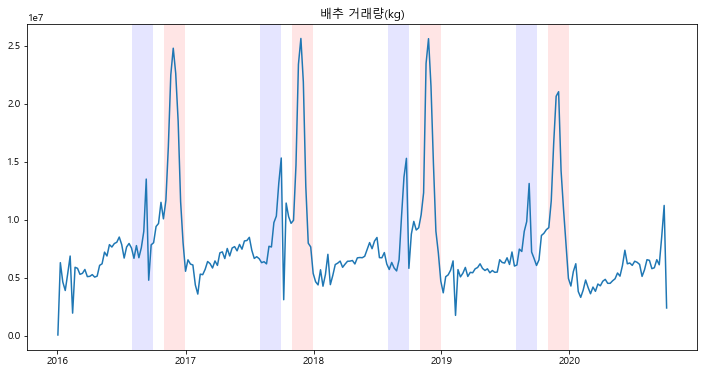

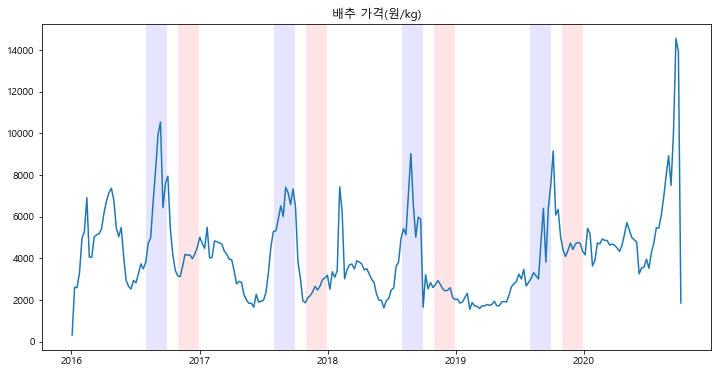

In [21]:
# 김장철에 거래량 상승하기 직전에 갑자기 거래량이 늘어나고 내려가는 이유는 뭔지
# 2019년 겨울에는 거래량 변화폭이 적은 이유는 뭔지
PUM_plot('배추', '거래량', 'W')
for year in range(2016, 2020):
    plt.axvspan(datetime(year, 8, 1), datetime(year, 9, 30), facecolor = "blue", alpha = 0.1)
    plt.axvspan(datetime(year, 11, 1), datetime(year, 12, 31), facecolor = "red", alpha = 0.1)
plt.show()

PUM_plot('배추', '가격', 'W')
for year in range(2016, 2020):
    plt.axvspan(datetime(year, 8, 1), datetime(year, 9, 30), facecolor = "blue", alpha = 0.1)
    plt.axvspan(datetime(year, 11, 1), datetime(year, 12, 31), facecolor = "red", alpha = 0.1)
plt.show()

# 배추 거래량은 김장시즌(11~12월)에 큰 폭으로 증가했지만 가격은 그렇지 않았고, 오히려 그보다 2~3개월 정도 앞선 8,9월에 가격이 증가하는 추세를 보인다. 이 기간에 거래량 또한 
# 11,12월의 증가량에 비해 작은 폭이지만 급증하고, 급락하는 추세를 보인다. 이게 가격의 변화와 연관이 있을 것 같다.
# 이건 왜 그럴까? 김장(가을)배추와 다른 배추로 나눠서 거래량과 가격의 변화를 살펴봐야겠다.

In [22]:
print(len(df[df.sum(axis = 1) == 0]))
print(len(df[(df.sum(axis = 1) == 0) & (df["요일"] != "일요일")]))
print(len(df[(df["요일"]=="일요일") & (df.sum(axis = 1) == 0)]))
print(len(df[(df["요일"]=="일요일") & (df.sum(axis = 1) != 0)]))

247
21
226
22


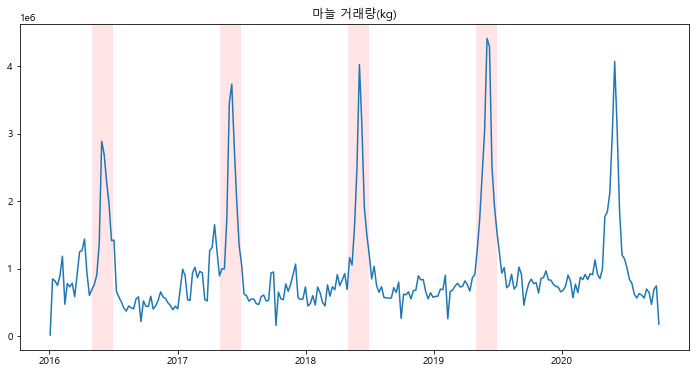

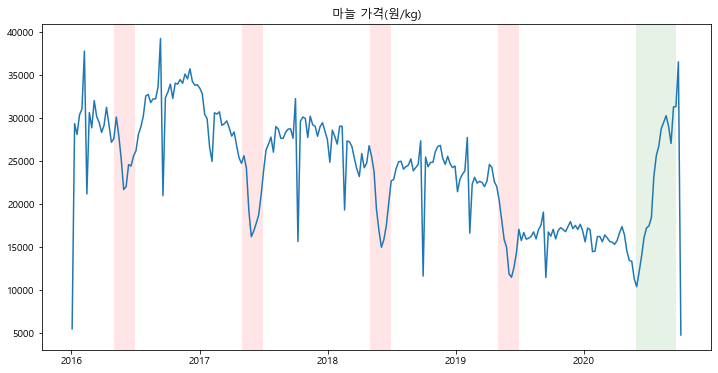

In [28]:
PUM_plot('마늘', '거래량', 'W')
for year in range(2016, 2020):
    plt.axvspan(datetime(year, 5, 1), datetime(year, 7, 1), facecolor = "red", alpha = 0.1)
PUM_plot('마늘', '가격', 'W')
for year in range(2016, 2020):
    plt.axvspan(datetime(year, 5, 1), datetime(year, 7, 1), facecolor = "red", alpha = 0.1)

plt.axvspan(datetime(2020, 5, 28), datetime(2020, 9, 20), facecolor = "green", alpha = 0.1)

plt.show()

# 마늘은 5~7월 구간에 거래량이 급증했다가 급락한다. 그 구간에서 가격은 하락하는 추세를 보인다.
# 마늘 가격은 4년간 조금씩 하락하는 추세를 보이다가 

In [24]:
df.columns

Index(['요일', '배추_거래량(kg)', '배추_가격(원/kg)', '무_거래량(kg)', '무_가격(원/kg)',
       '양파_거래량(kg)', '양파_가격(원/kg)', '건고추_거래량(kg)', '건고추_가격(원/kg)',
       '마늘_거래량(kg)', '마늘_가격(원/kg)', '대파_거래량(kg)', '대파_가격(원/kg)',
       '얼갈이배추_거래량(kg)', '얼갈이배추_가격(원/kg)', '양배추_거래량(kg)', '양배추_가격(원/kg)',
       '깻잎_거래량(kg)', '깻잎_가격(원/kg)', '시금치_거래량(kg)', '시금치_가격(원/kg)',
       '미나리_거래량(kg)', '미나리_가격(원/kg)', '당근_거래량(kg)', '당근_가격(원/kg)',
       '파프리카_거래량(kg)', '파프리카_가격(원/kg)', '새송이_거래량(kg)', '새송이_가격(원/kg)',
       '팽이버섯_거래량(kg)', '팽이버섯_가격(원/kg)', '토마토_거래량(kg)', '토마토_가격(원/kg)',
       '청상추_거래량(kg)', '청상추_가격(원/kg)', '백다다기_거래량(kg)', '백다다기_가격(원/kg)',
       '애호박_거래량(kg)', '애호박_가격(원/kg)', '캠벨얼리_거래량(kg)', '캠벨얼리_가격(원/kg)',
       '샤인마스캇_거래량(kg)', '샤인마스캇_가격(원/kg)'],
      dtype='object')

In [35]:
# 가격과 거래량을 나누어 봄
feature_price = []
for i in range(1,22):
    feature_price.append(df.columns[2*i])

feature_vol = []
for i in range(1,22):
    feature_vol.append(df.columns[2*i-1])

* 가격 한 번에 다 찍어보기

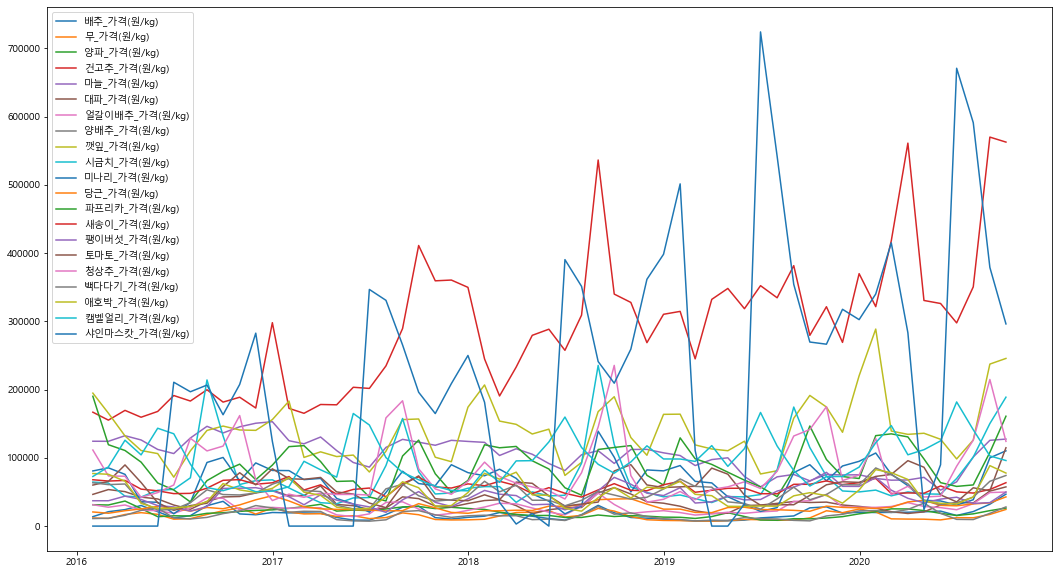

In [36]:
fig = plt.figure()
fig.set_size_inches(18, 10)

ax = fig.add_subplot()
ax.plot(df[feature_price].resample("M").sum(), label=feature_price)
ax.legend()

* 거래량 한 번에 다 찍어보기

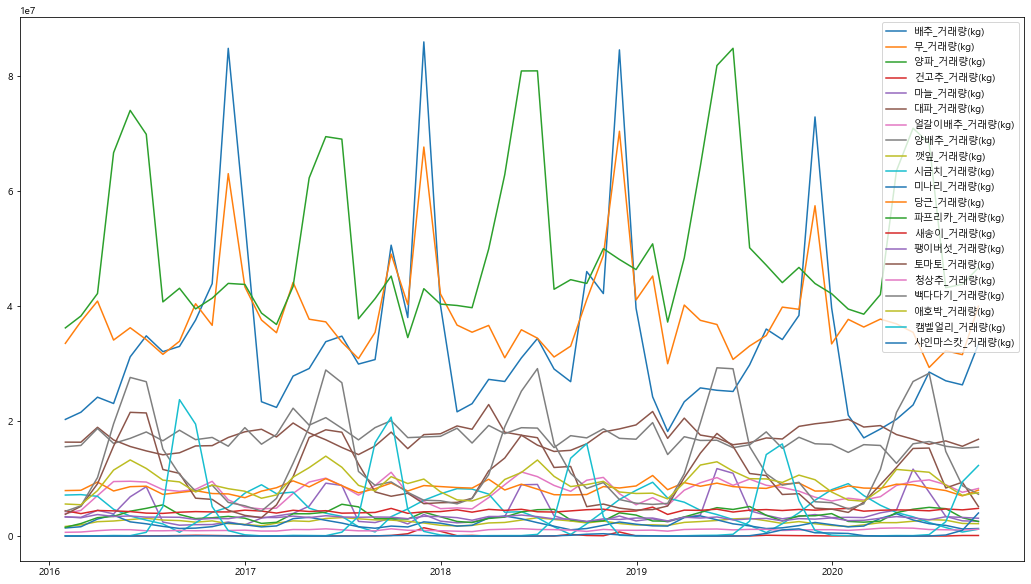

In [37]:
fig = plt.figure()
fig.set_size_inches(18, 10)

ax = fig.add_subplot()
ax.plot(df[feature_vol].resample("M").sum(), label=feature_vol)
ax.legend()